In [1]:
import os

In [2]:
train_cats_dir = "./Data1/cats_and_dogs_small/train/cats"
train_dogs_dir = "./Data1/cats_and_dogs_small/train/dogs"
test_cats_dir = "./Data1/cats_and_dogs_small/test/cats"
test_dogs_dir = "./Data1/cats_and_dogs_small/test/dogs"
validation_cats_dir = "./Data1/cats_and_dogs_small/validation/cats"
validation_dogs_dir = "./Data1/cats_and_dogs_small/validation/dogs"

print("train(개) 개수 :",len(os.listdir(train_dogs_dir)))
print("train(고양이) 개수 :",len(os.listdir(train_cats_dir)))
print("test(개) 개수 :",len(os.listdir(test_dogs_dir)))
print("test(고양이) 개수 :",len(os.listdir(test_cats_dir)))
print("validation(개) 개수 :",len(os.listdir(validation_dogs_dir)))
print("validation(고양이) 개수 :",len(os.listdir(validation_cats_dir)))

train(개) 개수 : 1000
train(고양이) 개수 : 1000
test(개) 개수 : 500
test(고양이) 개수 : 500
validation(개) 개수 : 500
validation(고양이) 개수 : 500


##### CF. 편향(bias)의 역할
    - https://de-novo.org/2018/04/17/%EC%9D%B8%EA%B3%B5%EC%8B%A0%EA%B2%BD%EB%A7%9D-%EC%9D%B4%ED%95%B4%ED%95%98%EA%B8%B0-1/
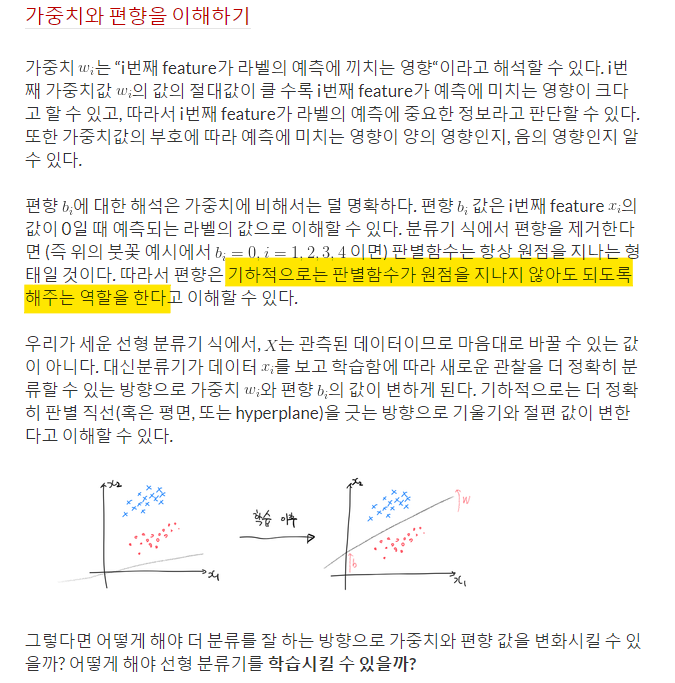

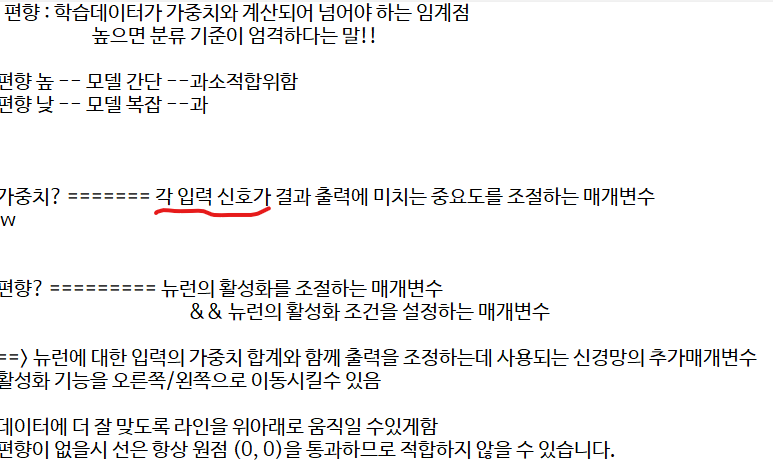

# 22th

### generator를 이용한 이미지 전처리
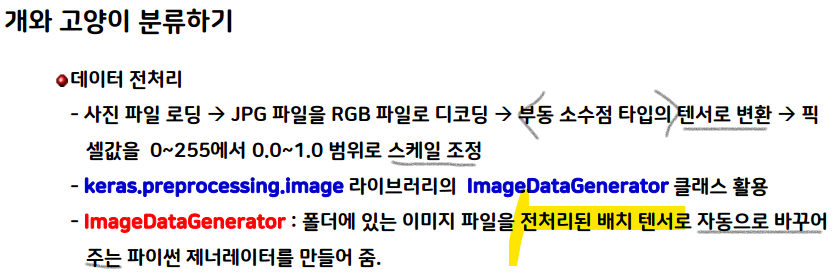

- ImageDataGenerator 클래스를 이용하여 객체를 생성한 뒤 
- flow_from_directory() 함수를 호출하여 제네레이터(generator)를 생성

In [3]:
# 이미지 전처리 (전처리(변환), 증식)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 픽셀값을 0-255 범위에서 0.0-1.0 범위로 변경
train_gen = ImageDataGenerator(rescale=1.0/255)
test_gen = ImageDataGenerator(rescale=1.0/255)
validation_gen = ImageDataGenerator(rescale=1.0/255)

# 폴더로부터 데이터를 가져와서 처리
train_dir = "./Data1/cats_and_dogs_small/train/"
test_dir = "./Data1/cats_and_dogs_small/test/"
validation_dir = "./Data1/cats_and_dogs_small/validation/"

train_generator = train_gen.flow_from_directory(
                    train_dir,                # 데이터를 가져올 폴더
                    target_size = (150,150),  # 이미지 <데이터> 크기를 동일하게 맞춤
                    batch_size = 20,          # 한 번에 읽어올 이미지의 개수
                    class_mode = "binary"     # 라벨링 방법 (디렉토리명에서 알파벳순으로 0부터 라벨링 함)
                    )                             # - binary : 0과 1만으로 라벨링
                                                  # - categorical : 0부터 폴더의 개수만큼 라벨링 (원핫인코딩을 함) ___ 변함
                                                  # - sparse : 0부터 폴더의 개수만큼 라벨링 (원핫인코딩을 하지 않음)
    
test_generator = test_gen.flow_from_directory(
                    test_dir,
                    target_size = (150,150),
                    batch_size = 20,
                    class_mode = "binary" 
                  )

validation_generator = validation_gen.flow_from_directory(
                        validation_dir,
                        target_size = (150,150),
                        batch_size = 20,
                        class_mode = "binary" 
                      )

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [4]:
train_generator.class_indices, test_generator.class_indices   ## cats가 0, dogs가 1인 라벨을 갖고있는 것을 확인

({'cats': 0, 'dogs': 1}, {'cats': 0, 'dogs': 1})

#### 신경망 초기화

In [5]:
import numpy as np
import tensorflow as tf

seed = 0
np.random.seed(seed)
tf.random.set_seed(seed)

#### 신경망 설계

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.layers import Dense, Dropout

model1 = Sequential()

# CNN층 (입력층)
#             필터수, 필터크기,    입력데이터 크기,                     활성화함수
model1.add(Conv2D(32, (3,3), input_shape=(150, 150, 3), padding="same", activation="relu"))
model1.add(MaxPooling2D(pool_size=2))    ## 1/2크기로

model1.add(Conv2D(64,  (3,3), padding="same", activation="relu"))
model1.add(MaxPooling2D(pool_size=2))

model1.add(Conv2D(128, (3,3), padding="same", activation="relu"))
model1.add(MaxPooling2D(pool_size=2))

model1.add(Flatten())

# 은닉층
model1.add(Dense(512, activation="relu"))
model1.add(Dropout(0.5))   ##50프로
model1.add(Dense(128, activation="relu"))
model1.add(Dropout(0.3))   ##30프로

# 출력층
model1.add(Dense(1, activation="sigmoid"))

model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 41472)             0

In [7]:
# class_mode : categorical 이라면 -->        categorical_crossentropy
# class_mode : sparse      이라면 --> sparse_categorical_crossentropy
model1.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["acc"])

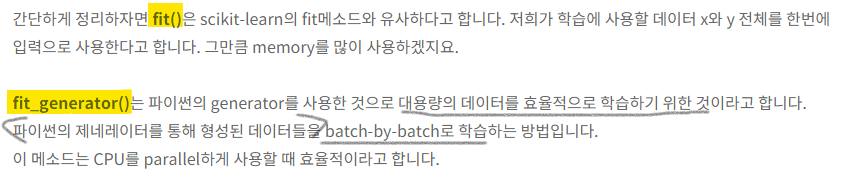

In [8]:
## fit()함수와 데이터 제네레이터를 사용할 수 있다는 것을 제외하고 동일한 기능을 하는 fit_generator() 

h1 = model1.fit_generator(generator=train_generator, ##훈련데이터셋을 제공할 제네레이터를 지정
                         epochs=20,                  ##전체 훈련 데이터셋에 대해 학습 반복횟수 지정
                         steps_per_epoch=100,        ##하나의 epoch당 사용할 스텝 수 지정 (배치사이즈 위에서 20으로 지정했으므로)
                         validation_data=validation_generator,  ##검증데이터셋을 제공할 제네레이터
                         validation_steps=50                    ##총 1000개의 검증샘플있고, 배치사이즈20이므로 1000/20 
                         )

model1.save_weights("./model/dogs_and_cats_001.hdf5")  ##훈련 끝나면 모델 저장

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 100 steps, validate for 50 steps
Epoch 1/20
100/100 [==============================] - 7s 73ms/step - loss: 0.7028 - acc: 0.4920 - val_loss: 0.6903 - val_acc: 0.5090
Epoch 2/20
100/100 [==============================] - 5s 52ms/step - loss: 0.6882 - acc: 0.5575 - val_loss: 0.6837 - val_acc: 0.5180
Epoch 3/20
100/100 [==============================] - 5s 53ms/step - loss: 0.6612 - acc: 0.6140 - val_loss: 0.6532 - val_acc: 0.6460
Epoch 4/20
100/100 [==============================] - 5s 53ms/step - loss: 0.6157 - acc: 0.6605 - val_loss: 0.6380 - val_acc: 0.6520
Epoch 5/20
100/100 [==============================] - 5s 54ms/step - loss: 0.5434 - acc: 0.7240 - val_loss: 0.6208 - val_acc: 0.6540
Epoch 6/20
100/100 [==============================] - 5s 53ms/step - loss: 0.4624 - acc: 0.7870 - val_loss: 0.7822 - val_acc: 0.6530
Epoch 7/20
100/100 [=============

#### 결과 시각화

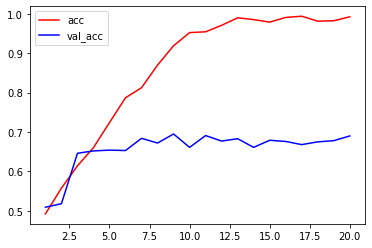

In [9]:
import matplotlib.pyplot as plt

acc = h1.history["acc"]
val_acc = h1.history["val_acc"]

epochs = range(1, len(acc) + 1)   ## len(acc)는 배치사이즈인 20이고, range(1, 20)은 1~19까지 결과물출력하므로 1 더해줌

       ## x축,  y축, 색상,  레이블명
plt.plot(epochs, acc,     'r', label='acc')
plt.plot(epochs, val_acc, 'b', label='val_acc')
plt.legend()

dropout 넣고 나니 좀 더 나아졌나?

- dropout 넣기 전
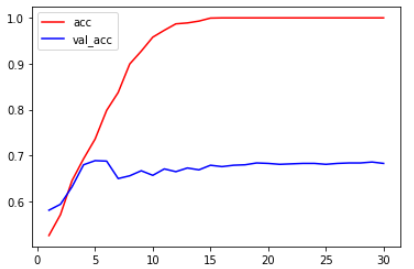

In [10]:
## 계산하는 방법으로써 '증식'
import numpy as np

pred = model1.predict_generator(test_generator)    ##테스트셋 데이터들을 예측해봐라!
##pred

p = np.where(pred>0.80, "개", "고양이")    ##0.8보다 크면 개, 작으면 고양이

for i in range(10):
    print(test_generator.filenames[i])
    print(p[i])

Instructions for updating:
Please use Model.predict, which supports generators.
cats\cat.1000.jpg
['고양이']
cats\cat.1001.jpg
['개']
cats\cat.1002.jpg
['고양이']
cats\cat.1003.jpg
['고양이']
cats\cat.1004.jpg
['고양이']
cats\cat.1005.jpg
['고양이']
cats\cat.1006.jpg
['개']
cats\cat.1007.jpg
['고양이']
cats\cat.1008.jpg
['개']
cats\cat.1009.jpg
['개']


### 증식(augmentation)을 통한 데이터 확장
    - 훈련데이터가 부족한 문제를 해결하기 위한 것
    - 데이터확장 : "훈련 데이터를 다양하게 변형"하여 변형된 새로운 훈련데이터처럼 사용함으로써 마치 훈련 데이터 수가 늘어난 효과를 얻는 것
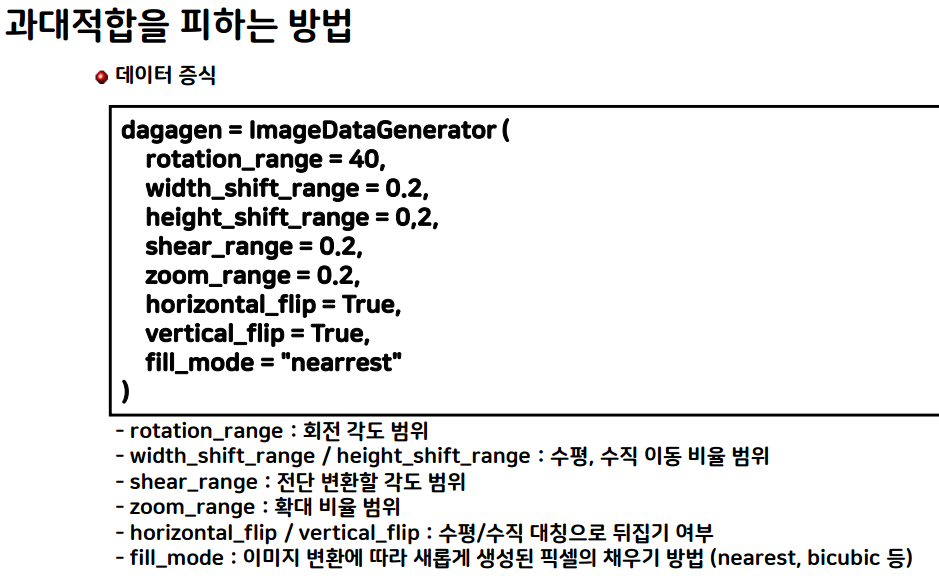

In [11]:
train_gen = ImageDataGenerator(rescale=1.0/255,
                              rotation_range=20,
                              width_shift_range=0.2,
                              height_shift_range=0.1, ##height는 많이변하니깐 10프로만 변형~~
                              shear_range=0.1,
                              zoom_range=0.1,
                              horizontal_flip=True,
                              fill_mode="nearest")  # 확대 시에 이미지가 깨지는 문제를 보정


## 검증데이터는 증식을 하면 안되므로 그대로 사용

test_gen = ImageDataGenerator(rescale=1.0/255)
validation_gen = ImageDataGenerator(rescale=1.0/255)

In [12]:
train_generator = train_gen.flow_from_directory(
                    train_dir,                
                    target_size = (150,150),
                    batch_size = 20,        
                    class_mode = "binary"    
                    )                            
                       
    
test_generator = test_gen.flow_from_directory(
                    test_dir,
                    target_size = (150,150),
                    batch_size = 20,
                    class_mode = "binary" 
                  )

validation_generator = validation_gen.flow_from_directory(
                        validation_dir,
                        target_size = (150,150),
                        batch_size = 20,
                        class_mode = "binary" 
                      )

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [13]:
model1.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["acc"])

h2 = model1.fit_generator(generator=train_generator,
                         epochs=20,
                         steps_per_epoch=100,
                         validation_data=validation_generator,
                         validation_steps=50
                         )

model1.save_weights("./model/dogs_and_cats_002.hdf5")

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 100 steps, validate for 50 steps
Epoch 1/20
100/100 [==============================] - 12s 119ms/step - loss: 0.8106 - acc: 0.6190 - val_loss: 0.6421 - val_acc: 0.6680
Epoch 2/20
100/100 [==============================] - 11s 113ms/step - loss: 0.6221 - acc: 0.6630 - val_loss: 0.5841 - val_acc: 0.7020
Epoch 3/20
100/100 [==============================] - 11s 114ms/step - loss: 0.5867 - acc: 0.6895 - val_loss: 0.5736 - val_acc: 0.7190
Epoch 4/20
100/100 [==============================] - 12s 115ms/step - loss: 0.5863 - acc: 0.6980 - val_loss: 0.5731 - val_acc: 0.7160
Epoch 5/20
100/100 [==============================] - 12s 116ms/step - loss: 0.5692 - acc: 0.7040 - val_loss: 0.5993 - val_acc: 0.7400
Epoch 6/20
100/100 [==============================] - 11s 113ms/step - loss: 0.5716 - acc: 0.7195 - val_loss: 0.5548 - val_acc: 0.7340
Epoch 7/20
100/100 [==============================] - 11s 114ms/step - loss: 0.5510 - acc: 0.7295

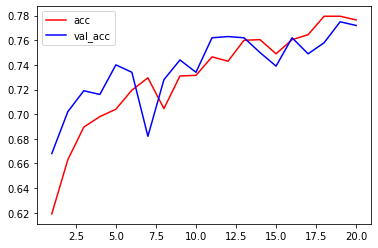

In [14]:
import matplotlib.pyplot as plt

acc = h2.history["acc"]
val_acc = h2.history["val_acc"]

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='acc')
plt.plot(epochs, val_acc, 'b', label='val_acc')
plt.legend()

- 증식을 한 가짜이미지라서 맞았다틀렸다 함 (~흔들흔들~)
- 증식만 했는데 훈련데이터도 어느정도 반영됐다!
- 이미지가 정~말~~ 없을 때 사용하는 증식
- val_acc가 67에서 75로 상승

### 전이학습(Transfer Learning) : 좋은 모델을 가져다가 붙여서 쓰는 것
    - 잘 된 신경망 가져다 붙이는 것 
    - 기존모델의 특성가져다가 쓰는 특성모델 추출방법 , 그대로가져와서 여기서돌리고 동결 / 살짝 미세조정(-->에서 증식 가능)
    
    - 1) 특성모델 추출방법
        - 보냈다가 값 가져오는것
        - 모델그대로가져와서 동결
    - 2) 미세조정 방법
        - 가지고온것에 w,b업데이트할수있도록 만드는것

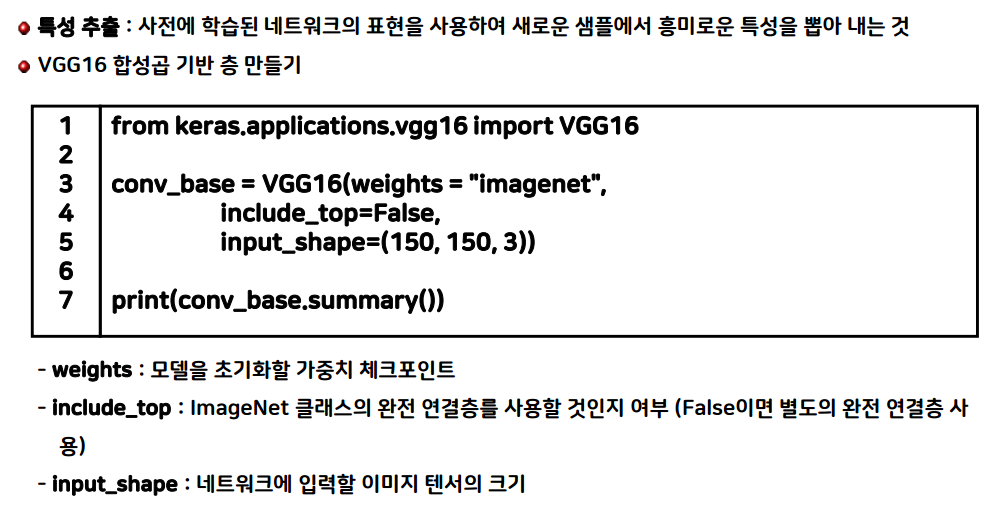
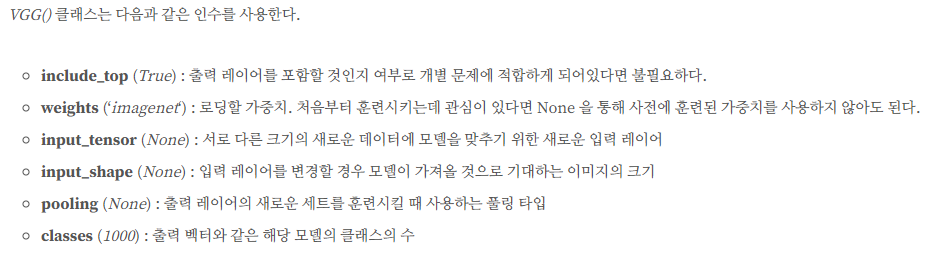

In [15]:
# VGG16 다운로드
from tensorflow.keras.applications import VGG16   # 여러 모델들 중 가져다 쓰기 좋은모델이라 VGG16 사용

# weights="imagenet" : 초기화할 가중치
# include_top = False : VGG16의 Dense 층을 가져올 것인지 여부
# input_shape=(150,150,3) : 입력 데이터 크기
conv_base = VGG16(weights="imagenet",
                 include_top = False,
                 input_shape =(150,150,3))   ##우리이미지랑 똑같이 만들어줌

In [16]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(rescale=1.0/255)    ##증식일단안할거니깐 train만 (VGG16으로 훈련시키려고하는것이므로)

train_dir = "./Data1/cats_and_dogs_small/train/"

# VGG16을 이용해서 특성을 추출하는 함수
def extract_feature(directory, count, size):  ### 이미지가들어있는폴더, 그안에들어있는갯수, 제너레이터에서 몇개씩 넘어오는가
    train_generator = train_gen.flow_from_directory(
                        directory,                
                        target_size = (150,150),  
                        batch_size = size,          
                        class_mode = "binary"     
                        )  
    # VGG16의 결과로 받을 최종 특성    ###미리 VGG에서 받을것들 초기화한 두 라인(feature, label)
    feature = np.zeros(shape=(count, 4, 4, 512))  ##VGG 덴스층에서 넘어오는데이터가 4,4,512가 때문
    # 라벨의 수
    label = np.zeros(shape=count)  ##넘어오는수마다(이미지마다) 라벨있으므로 =count
    
                           
    
    i = 0   ###카운트를위한 i
    
    # VGG16에서 predict() 함수를 이용하여 배치 사이즈만큼
    # 이미지의 특성과 라벨을 가져옴!
    for image_data, label_data in train_generator:             ### 위에서 VGG돌아가고 여기에 <<feature와 label>>넘어옴  #이미지, 라벨(여기선 0과1)
        # VGG16에 generator에서 넘어온 이미지 데이터를 넣어 줌 (--> 그러면 4*4*512인 특성이 넘어오겠지~~~)
        # predict() : 추출된 특성맵을 반환
        feature_batch = conv_base.predict(image_data)          ###VGG거쳐서 결과값 반환
        feature[i*size:(i+1)*size] = feature_batch             ### i를count해서 첫번째20개채우고 두번째20개채우고... 채워주기(왜 20개? batch_size떄문)
        label[i*size:(i+1)*size] = label_data                  ### generator에서 넘어온 라벨값(0,1) 넣어준것
        
        i = i + 1
        
        # 이미지 개수보다 커지면 중지해라!
        if i*size >= count:   ##count에 있는것은 이미지의 갯수
            break
    return feature, label

*scaling한 <<이미지와 label>>이 넘어오는 generator

In [18]:
train_feature, train_label = extract_feature(train_dir, 2000, 20)  ##train_dir폴더에있는 2000개의 이미지를 20개씩(간다고) 넣어줌. 배치사이즈20개씩
test_feature, test_label = extract_feature(test_dir, 1000, 20)
validation_feature, validation_label = extract_feature(validation_dir, 1000, 20)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


# 23th

In [19]:
# VGG16에서 넘어온 데이터를 Dense()에 맞도록 변경
train_feature = np.reshape(train_feature, (2000, 4*4*512))
test_feature = np.reshape(test_feature, (1000, 4*4*512))
validation_feature = np.reshape(validation_feature, (1000, 4*4*512))

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

model3 = Sequential()

# 은닉층
model3.add(Dense(256, input_dim=4*4*512, activation="relu"))
model3.add(Dropout(0.5))

# 출력층
model3.add(Dense(1, activation="sigmoid"))

model3.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 2,097,665
Trainable params: 2,097,665
Non-trainable params: 0
_________________________________________________________________


In [21]:
model3.compile(loss="binary_crossentropy",
               optimizer="adam",
               metrics=["acc"])

In [22]:
h3 = model3.fit(train_feature, train_label,
               epochs=20,
               batch_size=20,
               validation_data=(validation_feature, validation_label))

Train on 2000 samples, validate on 1000 samples
Epoch 1/20
2000/2000 [==============================] - 1s 378us/sample - loss: 0.6165 - acc: 0.7545 - val_loss: 0.3186 - val_acc: 0.8680
Epoch 2/20
2000/2000 [==============================] - 0s 163us/sample - loss: 0.2883 - acc: 0.8785 - val_loss: 0.2762 - val_acc: 0.8830
Epoch 3/20
2000/2000 [==============================] - 0s 168us/sample - loss: 0.2247 - acc: 0.9130 - val_loss: 0.2759 - val_acc: 0.8730
Epoch 4/20
2000/2000 [==============================] - 0s 169us/sample - loss: 0.1851 - acc: 0.9340 - val_loss: 0.2524 - val_acc: 0.8850
Epoch 5/20
2000/2000 [==============================] - 0s 160us/sample - loss: 0.1483 - acc: 0.9480 - val_loss: 0.2702 - val_acc: 0.8780
Epoch 6/20
2000/2000 [==============================] - 0s 163us/sample - loss: 0.1277 - acc: 0.9505 - val_loss: 0.2634 - val_acc: 0.8900
Epoch 7/20
2000/2000 [==============================] - 0s 162us/sample - loss: 0.1108 - acc: 0.9615 - val_loss: 0.3307 - va

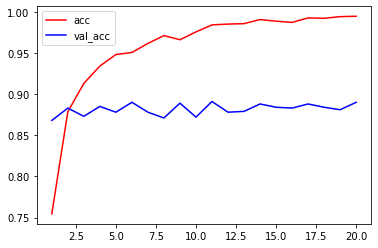

In [23]:
import matplotlib.pyplot as plt

acc = h3.history["acc"]
val_acc = h3.history["val_acc"]

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='acc')
plt.plot(epochs, val_acc, 'b', label='val_acc')
plt.legend()

train에 너무 맞춰진 과대적합

### "데이터 증식을 사용하여" 특성추출 방식의 전이학습
    - 이전방식은 함수처럼 가져다가 쓰는 특성추출 방식의 전이학습
    - 동결은 무엇인가!

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights="imagenet",
                 include_top = False,
                 input_shape =(150,150,3))   ##우리이미지랑 똑같이 만들어줌

model4 = Sequential()

### 이아래는 CNN층
# VGG16 모델의 Convnet을 그대로 추가      ## 함수로 쓴것이 아닌 기존모델에 그냥 추가
model4.add(conv_base)

model4.add(Flatten())

model4.add(Dense(256, activation="relu"))  ## 바로연결되어있으니 input_dim은 잡을 필요없음(위에서썼으니깐~~ 만약여기부터 시작한다면 써줄 것)
model4.add(Dropout(0.5))

model4.add(Dense(1, activation="sigmoid"))

model4.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


### 동결 : 전이학습으로 가져온 모델의 파라미터가 업데이터가 되지 않도록 방지하는 것

In [25]:
print("동결 전의 훈련되는 가중치 개수 :", len(model4.trainable_weights))

동결 전의 훈련되는 가중치 개수 : 30


In [26]:
# 동결
conv_base.trainable = False  ##훈련시켜도 훈련안하겠다는 것

In [27]:
print("동결 후의 훈련되는 가중치 개수 :", len(model4.trainable_weights))   ##우리가 만든 4개의 층만 훈련하겠다는 것~~

동결 후의 훈련되는 가중치 개수 : 4


### 증식 사용

In [28]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(rescale=1.0/255,      ##증식위한 rescale
                              rotation_range=20,     ##회전
                              width_shift_range=0.2,
                              height_shift_range=0.1, ##height는 많이변하니깐 10프로만 변형~~
                              shear_range=0.1,
                              zoom_range=0.1,
                              horizontal_flip=True,
                              fill_mode="nearest")  # 확대 시에 이미지가 깨지는 문제를 보정

test_gen = ImageDataGenerator(rescale=1.0/255)
validation_gen = ImageDataGenerator(rescale=1.0/255)

In [29]:
train_generator = train_gen.flow_from_directory(
                    train_dir,                
                    target_size = (150,150),
                    batch_size = 20,        
                    class_mode = "binary"    
                    )                            
                       
    
test_generator = test_gen.flow_from_directory(
                    test_dir,
                    target_size = (150,150),
                    batch_size = 20,
                    class_mode = "binary" 
                  )

validation_generator = validation_gen.flow_from_directory(
                        validation_dir,
                        target_size = (150,150),
                        batch_size = 20,
                        class_mode = "binary" 
                      )

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [30]:
#from tensorflow.keras import optimizers

model4.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["acc"])

In [31]:
h4 = model4.fit(train_generator,
               epochs=20,
               steps_per_epoch=100,       ##20개씩 땡겨오고 2000개이므로 100  ##20개씩넘어오니 batch_size는 필요없음
               validation_data=validation_generator,
               validation_steps=50)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 100 steps, validate for 50 steps
Epoch 1/20
100/100 [==============================] - 13s 125ms/step - loss: 0.5714 - acc: 0.7415 - val_loss: 0.3156 - val_acc: 0.8640
Epoch 2/20
100/100 [==============================] - 12s 121ms/step - loss: 0.3714 - acc: 0.8360 - val_loss: 0.2755 - val_acc: 0.8870
Epoch 3/20
100/100 [==============================] - 12s 120ms/step - loss: 0.3193 - acc: 0.8635 - val_loss: 0.2658 - val_acc: 0.8860
Epoch 4/20
100/100 [==============================] - 12s 124ms/step - loss: 0.3202 - acc: 0.8670 - val_loss: 0.2631 - val_acc: 0.8900
Epoch 5/20
100/100 [==============================] - 12s 121ms/step - loss: 0.2942 - acc: 0.8770 - val_loss: 0.2720 - val_acc: 0.8890
Epoch 6/20
100/100 [==============================] - 12s 118ms/step - loss: 0.2966 - acc: 0.8675 - val_loss: 0.2729 - val_acc: 0.8860
Epoch 7/20
100/100 [==============================] - 12s 118ms/step - loss: 0.2791 - acc: 0.8735

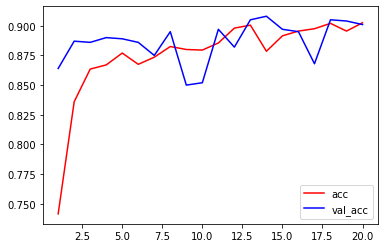

In [32]:
import matplotlib.pyplot as plt

acc = h4.history["acc"]
val_acc = h4.history["val_acc"]

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='acc')
plt.plot(epochs, val_acc, 'b', label='val_acc')
plt.legend()

증식을 했더니 과대적합도 거의 사라지고, 90%가까이 올랐다!

### 미세조정을 이용한 전이학습
- 미세조정 : 가져온 모델의 하단 층 일부만 업데이트 되도록 하는 것

In [33]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

블럭5층까지 있고, 블럭5층만풀어서 업데이트 되도록 해보자

In [34]:
# block5만 동결을 품
################# conv_base.trainable = True   ##위에서 False인게 마지막

set_trainable = False

# layer를 하나씩 가져와서 이름이 block5_conv1인 layer부터 동결을 해제
for layer in conv_base.layers:  ## Out[50] 하나하나가져오자는것
    if layer.name == "block5_conv1":    ##얘를 만나면... 밑에층까지 동결 다 풀어버려라
        set_trainable = True    ## set_trainable를 True로 바꿔서 동결 풀어라
    
    if set_trainable:
        layer.trainable = True           ### 만약 set_trainable이 true라면, 층이 훈련가능(업데이트) 되도록 하라!
    else:
        layer.trainabler = False         ### 그렇지않은경우는 업데이트 되지 않도록 하라!
                       ### for문 이전 set_trainable 초기화를 False로 해줬기때문에, 
                       ### blcok5_conv1 만나기 전까지의 모든 set_trainable은 False에 해당하고, 그 층들은 업데이트 하지 않을것임

In [35]:
#conv_base.layers

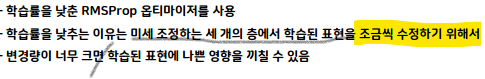

In [36]:
from tensorflow.keras.optimizers import RMSprop #############
    
model4.compile(loss="binary_crossentropy",
              #######optimizer="adam",
              optimizer=RMSprop(lr=1e-5),       ############## 
              metrics=["acc"])

h5 = model4.fit(train_generator,
               epochs=20,
               steps_per_epoch=100,       ##20개씩 땡겨오고 2000개이므로 100  ##20개씩넘어오니 batch_size는 필요없음
               validation_data=validation_generator,
               validation_steps=50)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 100 steps, validate for 50 steps
Epoch 1/20
100/100 [==============================] - 13s 125ms/step - loss: 0.2197 - acc: 0.9065 - val_loss: 0.2416 - val_acc: 0.9010
Epoch 2/20
100/100 [==============================] - 12s 118ms/step - loss: 0.2024 - acc: 0.9145 - val_loss: 0.2424 - val_acc: 0.9020
Epoch 3/20
100/100 [==============================] - 12s 118ms/step - loss: 0.2099 - acc: 0.9035 - val_loss: 0.2450 - val_acc: 0.9000
Epoch 4/20
100/100 [==============================] - 12s 118ms/step - loss: 0.2049 - acc: 0.9155 - val_loss: 0.2476 - val_acc: 0.9000
Epoch 5/20
100/100 [==============================] - 12s 118ms/step - loss: 0.1996 - acc: 0.9160 - val_loss: 0.2487 - val_acc: 0.9000
Epoch 6/20
100/100 [==============================] - 12s 118ms/step - loss: 0.1857 - acc: 0.9235 - val_loss: 0.2508 - val_acc: 0.8980
Epoch 7/20
100/100 [==============================] - 12s 118ms/step - loss: 0.1804 - acc: 0.9215

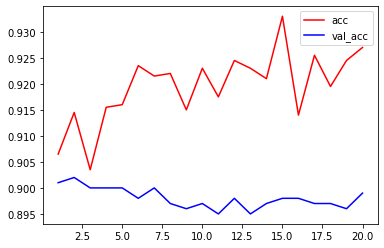

In [37]:
import matplotlib.pyplot as plt

acc = h5.history["acc"]
val_acc = h5.history["val_acc"]

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='acc')
plt.plot(epochs, val_acc, 'b', label='val_acc')
plt.legend()